### 1d-laplace demo
### 函数库导入

In [13]:
import numpy as np
import torch
import torch.nn as nn
from basic_model import DeepModel_single, gradients
from visual_data import matplotlib_vision

import time
from tqdm import trange
import matplotlib.pyplot as plt

#### 1d-Laplace方程
求解 u(x)
$$

    \frac{\partial^2 u}{\partial x^2}  = 0\\
    u(-1) = 0\\
    u( 1) = 1\\
$$
解为 $ u(x)= \frac{x+1}{2} $

In [14]:
import os
name = 'Laplace-1d'
work_path = os.path.join('work', name)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)

class Net(DeepModel_single):
    def __init__(self, planes):
        super(Net, self).__init__(planes, active=nn.ReLU())

    def equation(self, inn_var, out_var):
        dudx = gradients(out_var, inn_var)
        d2udx2 = gradients(dudx, inn_var)
        return d2udx2

#### 数据生成

Text(0, 0.5, '$y$')

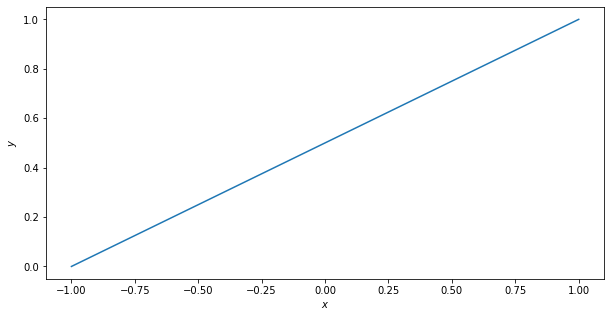

In [15]:
nodes = np.linspace(-1, 1, 101, dtype=np.float32)[:, None]
field = np.linspace(0, 1, 101, dtype=np.float32)[:, None]
bounds_ind = [0, 100]
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nodes_train = torch.tensor(nodes, dtype=torch.float32).to(device)
field_train = torch.tensor(field, dtype=torch.float32).to(device)

plt.figure(figsize=(10, 5))
plt.plot(nodes, field)
plt.xlabel('$x$')
plt.ylabel('$y$')

#### 网络建立

In [16]:
# 建立网络
Net_model = Net(planes=[1, 16, 16, 1]).to(device)
# 损失函数
L2loss = nn.MSELoss()
# 优化算法
Optimizer = torch.optim.Adam(Net_model.parameters(), lr=0.001, betas=(0.7, 0.9))
# 下降策略
Scheduler = torch.optim.lr_scheduler.MultiStepLR(Optimizer, milestones=[1000, 2000], gamma=0.1)
# 可视化
Visual = matplotlib_vision('/')

#### batch的训练及预测过程

In [17]:
def train(inn_var, bounds, out_true, model, Loss, optimizer, scheduler, log_loss):

    def closure():

        optimizer.zero_grad()
        out_var = model(inn_var)
        res_i = model.equation(inn_var, out_var)
        bcs_loss = Loss(out_var[bounds], out_true[bounds])
        eqs_loss = Loss(res_i, torch.zeros_like(res_i))

        loss_batch = bcs_loss + eqs_loss
        loss_batch.backward()

        data_loss = Loss(out_var, out_true)
        log_loss.append([eqs_loss.item(), bcs_loss.item(), data_loss.item()])

        return loss_batch

    optimizer.step(closure)
    scheduler.step()

def inference(inn_var, model):

    out_pred = model(inn_var)
    equation = model.equation(inn_var, out_pred)

    return out_pred, equation

#### 整体训练迭代

In [18]:
star_time = time.time()
log_loss = []
pbar = trange(1500)

inn_var = nodes_train
inn_var.requires_grad_(True)
# Training
for iter in pbar:

    learning_rate = Optimizer.state_dict()['param_groups'][0]['lr']
    train(inn_var, bounds_ind, field_train, Net_model, L2loss, Optimizer, Scheduler, log_loss)

    # if iter > 0 and iter % 200 == 0:
    # print('iter: {:6d}, lr: {:.3e}, eqs_loss: {:.3e}, dat_loss: {:.3e}, bon_loss1: {:.3e}, cost: {:.2f}'.
    #       format(iter, learning_rate, log_loss[-1][0], log_loss[-1][-1], log_loss[-1][1], time.time()-star_time))

    pbar.set_postfix({'lr': learning_rate, 'dat_loss': log_loss[-1][-1], 'cost:':  time.time()-star_time,
                      'eqs_loss': log_loss[-1][0], 'bcs_loss': log_loss[-1][1], })
torch.save({'log_loss': log_loss, 'model': Net_model.state_dict(), }, os.path.join(work_path, 'latest_model.pth'))

100%|██████████| 1500/1500 [00:05<00:00, 269.19it/s, lr=0.0001, dat_loss=0.0241, cost:=5.57, eqs_loss=0, bcs_loss=5.16e-11]


#### 损失函数可视化

D:\Code\PINNs_demo\visual_data.py:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.semilogy()
D:\Code\PINNs_demo\visual_data.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yticks(fontproperties='Times New Roman', size=self.font["size"])


Text(0.5, 1.0, 'training loss')

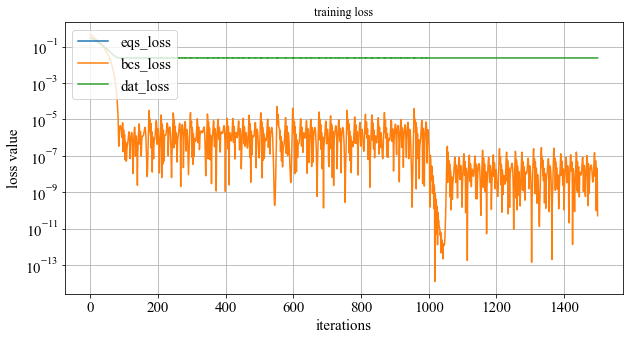

In [19]:
plt.figure(2, figsize=(10, 5))
plt.clf()
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 0], 'eqs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'bcs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, -1], 'dat_loss')
plt.title('training loss')

#### 预测结果可视化

Text(0.5, 1.0, 'equation residual')

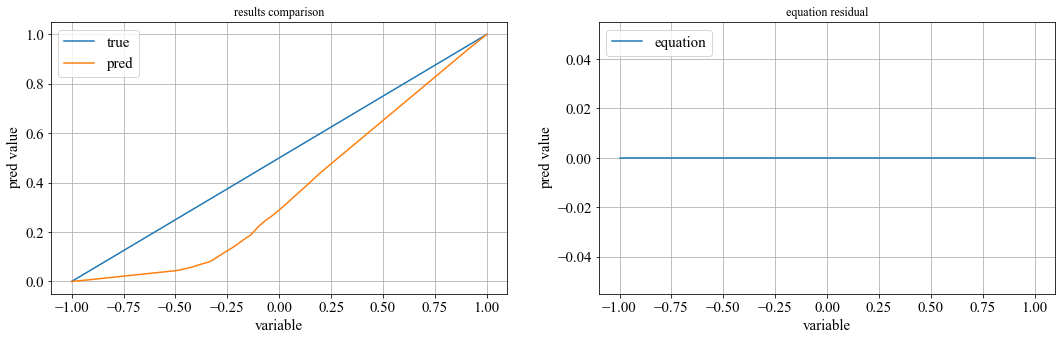

In [20]:
field_pred, equation = inference(nodes_train, Net_model)
plt.figure(3, figsize=(18, 5))
plt.clf()
plt.subplot(121)
Visual.plot_value(nodes_train.detach().cpu().numpy(), field_train.cpu().numpy(), 'true')
Visual.plot_value(nodes_train.detach().cpu().numpy(), field_pred.cpu().detach().numpy(), 'pred')
plt.title('results comparison')

plt.subplot(122)
Visual.plot_value(nodes_train.detach().cpu().numpy(), equation.detach().cpu().numpy(), 'equation')
plt.title('equation residual')